In [ ]:
import h5py
import numpy as np

# Path to your HDF5 file
file_path = '5G_dataset/5G_training_data.hdf5'

# Create an empty dictionary to store NumPy arrays
data_dict = {}

# Open the HDF5 file
with h5py.File(file_path, 'r') as hdf:
    # Iterate over all datasets in the file
    for key in hdf.keys():
        dataset = hdf[key][:]
        data_dict[key] = dataset  # Store each dataset into the dictionary

# Now, you can access individual datasets as NumPy arrays
A_ID = data_dict['A_ID']
B_ID = data_dict['B_ID']
CIR_I = data_dict['CIR_I']
CIR_R = data_dict['CIR_R']
POS_X = data_dict['POS_X']
POS_Y = data_dict['POS_Y']
TD = data_dict['TD']
TD_OFFSET = data_dict['TD_OFFSET']
TIME_STAMP = data_dict['TIME_STAMP']

# For verification, print shapes of arrays
for key, value in data_dict.items():
    print(f"{key} shape: {value.shape}")

In [ ]:
CIR=CIR_R+ 1j*CIR_I

In [ ]:
grt_pos=np.stack((POS_X, POS_Y), axis=1)

In [ ]:
def feature_extraction_F1(cir_matrix):
    R = cir_matrix * np.conj(cir_matrix)
    r = R.flatten()
    r_real = np.real(r)
    r_imag = np.imag(r)
    r_R = np.concatenate((r_real, r_imag))
    feature_vector = r_R / np.linalg.norm(r_R)
    return feature_vector

features_F1_cir = np.array([feature_extraction_F1(cir) for cir in CIR])
print("Shape of Features (F1_cir):", features_F1_cir.shape)

In [ ]:
features_F1_cir[0]

In [ ]:
from sklearn.model_selection import train_test_split
X_train, x1, y_train, y1 = train_test_split(features_F1_cir, grt_pos, test_size=0.4, random_state=42)
X_test, X_pred, y_test, y_pred = train_test_split(x1, y1, test_size=0.5, random_state=42)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.scatter(y_pred[:, 0], y_pred[:, 1], c='blue', label='Ground Truth', alpha=0.5)
plt.title('Ground Truth Positions for the pred set')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(10, 10))
plt.scatter(y_test[:, 0], y_test[:, 1], c='blue', label='Ground Truth', alpha=0.5)
plt.title('Ground Truth Positions for the Test Set')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(10, 10))
plt.scatter(y_train[:, 0], y_train[:, 1], c='blue', label='Ground Truth', alpha=0.5)
plt.title('Ground Truth Positions for the train set')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
from scipy.special import softmax

def build_grid(grid_size=30, space_bounds=None):
    (xmin, xmax), (ymin, ymax) = space_bounds
    x_lin = np.linspace(xmin, xmax, grid_size)
    y_lin = np.linspace(ymin, ymax, grid_size)
        
    xv, yv = np.meshgrid(x_lin, y_lin)
    grid_points = np.stack([xv.ravel(), yv.ravel()], axis=1)
    return grid_points

def compute_soft_probability_maps(positions, grid_points, temperature=.1):
    N = positions.shape[0]
    K = grid_points.shape[0]
    dists = np.linalg.norm(positions[:, np.newaxis, :] - grid_points[np.newaxis, :, :], axis=2)
    sim_scores = -dists / temperature
    prob_maps = softmax(sim_scores, axis=1)
    return prob_maps

def estimate_positions_from_maps(prob_maps, grid_points):
    return np.matmul(prob_maps, grid_points)

def generate_all_probability_maps(positions, grid_size=30, temperature=.1):
    x_min, x_max = positions[:, 0].min(), positions[:, 0].max()
    y_min, y_max = positions[:, 1].min(), positions[:, 1].max()
    print("Position bounds:", (x_min, x_max), (y_min, y_max))
    grid_points = build_grid(grid_size, space_bounds=((x_min, x_max), (y_min, y_max)))
    print("Grid points shape:", grid_points.shape)
    prob_maps = compute_soft_probability_maps(positions, grid_points, temperature=temperature)

    est_locations = estimate_positions_from_maps(prob_maps, grid_points)

    return prob_maps, est_locations, grid_points

In [ ]:
def plot_heatmap(prob_map, grid_points, title="Heatmap"):
    plt.figure(figsize=(8, 6))
    plt.imshow(prob_map.reshape(30, 30), extent=(grid_points[:, 0].min(), grid_points[:, 0].max(),
                                                  grid_points[:, 1].min(), grid_points[:, 1].max()),
               origin='lower', cmap='hot', alpha=0.7)
    plt.colorbar(label='Probability')
    plt.title(title)
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.show()

In [ ]:
prob_map, est_locations, grid_points = generate_all_probability_maps(grt_pos, grid_size=30, temperature=0.1)

In [ ]:
prob_map_test, est_locations_test, grid_points_test = generate_all_probability_maps(y_test, grid_size=30, temperature=0.1)
prob_map_train, est_locations_train, grid_points_train = generate_all_probability_maps(y_train, grid_size=30, temperature=0.1)
prob_map_pred, est_locations_pred, grid_points_pred = generate_all_probability_maps(y_pred, grid_size=30, temperature=0.1)

In [ ]:
plt.figure(figsize=(10, 10))
plt.scatter(y_test[:, 0], y_test[:, 1], c='blue', label='Ground Truth (Test)', alpha=0.5)
plt.scatter(est_locations_test[:, 0], est_locations_test[:, 1], c='red', label='Estimated (Test)', alpha=0.5)
plt.title('Estimated vs Ground Truth Positions (Test Set)')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import tensorflow as tf
from keras import layers, models, regularizers

def build_csi_probmap_mlp(input_dim: int = 256,hidden_units: tuple = (1024, 512, 512,512),dropout_rate: float = 0.2,l2_coeff: float = 1e-4) -> tf.keras.Model:
    inputs = layers.Input(shape=(input_dim,))
    x = inputs
    for i, width in enumerate(hidden_units, start=1):
        x = layers.Dense(width, activation=tf.nn.gelu, kernel_regularizer=regularizers.l2(l2_coeff))(x)
        x = layers.Dropout(dropout_rate)(x)
    logits = layers.Dense(900, activation=None)(x)
    outputs = layers.Activation("softmax")(logits)
    return models.Model(inputs, outputs)

In [ ]:
pred_ds = tf.data.Dataset.from_tensor_slices((X_pred, prob_map_pred))
pred_ds = pred_ds.shuffle(buffer_size=1024).batch(32)

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, prob_map_train))
train_ds = train_ds.shuffle(buffer_size=1024).batch(32)

In [ ]:
test_ds = tf.data.Dataset.from_tensor_slices((X_test, prob_map_test))
test_ds = test_ds.shuffle(buffer_size=1024).batch(32)

In [ ]:
model2 = build_csi_probmap_mlp()
optimizer = tf.keras.optimizers.Adam(learning_rate=4e-4)
model2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model2.fit(train_ds, epochs=100, validation_data=pred_ds)

In [ ]:
predicted_maps = model2.predict(X_pred)
plot_heatmap(predicted_maps[2], grid_points_pred, title="Predicted Heatmap for First Test Position")
print(f"Estimated :- {estimate_positions_from_maps(predicted_maps, grid_points_pred)[2]}")
print(f"Ground Truth :- {y_pred[2]}")
plot_heatmap(prob_map_pred[2], grid_points_pred, title="Heatmap for First Test Position")
predicted_positions = np.matmul(predicted_maps, grid_points_pred)
mae = np.mean(np.abs(y_pred - predicted_positions), axis=0)
print("Mean Absolute Error (Position Predictions):", mae)

In [ ]:
jk=estimate_positions_from_maps(predicted_maps, grid_points_pred)

In [ ]:
plt.figure(figsize=(10, 10))
plt.scatter(y_pred[:, 0], y_pred[:, 1], c='blue', label='Ground Truth (Test)', alpha=0.7)
plt.scatter(jk[:, 0], jk[:, 1], c='red', label='Estimated (Test)', alpha=0.1)
plt.title('Estimated vs Ground Truth Positions (Test Set)')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
X_train.shape

In [ ]:
# import tensorflow as tf
# import math

# def _generate_random_sequence(batch, lp, cp_len, gen):
#     """Internal helper that fabricates a complex perturbation with optional CP."""
#     # Amplitude A_k ∼ U([0,1]) and phase φ_k ∼ U([0,2π))
#     print("Generating random sequence with batch size:", batch, "and length:", lp)
#     A   = gen.uniform((batch, lp), 0.0, 1.0, dtype=tf.float32)
#     phi = gen.uniform((batch, lp), 0.0, 2.0 * math.pi, dtype=tf.float32)

#     base = tf.complex(A * tf.cos(phi), A * tf.sin(phi))        # shape (batch, lp)

#     if cp_len:
#         cp   = base[:, -cp_len:]                               # last cp_len samples
#         base = tf.concat([cp, base], axis=-1)                  # shape (batch, lp+cp_len)

#     # Unit‑norm normalisation of the *entire* transmit vector
#     norm = tf.linalg.norm(base, axis=-1, keepdims=True)
#     return base / norm                                         # ℓ₂‑norm = 1

# def random_attack(cir, *, lp=None, cp_len=0,
#                   epsilon=1.0, seed=None, align='pad'):
#     """
#     Applies the stochastic attack with user‑selectable Lp and cyclic prefix.

#     Parameters
#     ----------
#     cir : tf.Tensor  (m, 256)
#         CIR matrix.
#     lp : int, optional
#         Desired perturbation length *before* CP (defaults to 256).
#     cp_len : int, optional
#         Cyclic‑prefix length (0 ⇒ none).
#     epsilon : float
#         Global scaling of attack magnitude.
#     seed : int, optional
#         RNG seed for reproducibility.
#     align : {'crop','pad'}
#         Strategy when (lp+cp_len) ≠ 256.
#     """
#     lp = (lp or cir.shape[-1])
#     gen = (tf.random.Generator.from_seed(seed) if seed is not None
#            else tf.random.Generator.from_non_deterministic_state())
#     batch = tf.shape(cir)[0]

#     perturb_r = _generate_random_sequence(batch, lp, cp_len, gen)

#     feat_len  = tf.shape(cir)[-1]
#     pert_len  = tf.shape(perturb_r)[-1]

#     if pert_len > feat_len:                                 # need to shrink
#         perturb_r = perturb_r[:, :feat_len] if align == 'crop' else \
#                     tf.slice(perturb_r, [0, 0], [-1, feat_len])
#     elif pert_len < feat_len:                               # need to expand
#         pad = feat_len - pert_len
#         if align == 'pad':
#             padding_ones = tf.ones((batch, pad), dtype=perturb_r.dtype)
#             perturb_r = tf.concat([perturb_r, padding_ones], axis=-1)
#         else:                                               # default crop
#             perturb_r = tf.concat([perturb_r,
#                                     tf.zeros((batch, pad), tf.float32)], axis=-1)
    
#     return cir * perturb_r

In [116]:
# Converting CIR to CFR
CFR = (tf.signal.fft(CIR)).numpy()

In [117]:
CIR.shape

(113203, 128)

In [118]:
CFR.shape

(113203, 128)

In [119]:
import numpy as np
from scipy.signal import convolve

def random_attack(CFR, *, lp=None, cp_len=0, epsilon=1.0, align='pad'):
    batch_size, n_subcarriers = CFR.shape
    A = np.random.uniform(0, 1, (batch_size, lp))  
    phi = np.random.uniform(0, 2 * np.pi, (batch_size, lp))
    base = A * (np.cos(phi) + 1j * np.sin(phi))  # shape (batch, lp)

    if cp_len:
        cp = base[:, -cp_len:]
        base = np.concatenate([cp, base], axis=-1)  # shape (batch, lp + cp_len)

    # Normalize each perturbation vector to unit ℓ₂ norm
    norm = np.linalg.norm(base, axis=-1, keepdims=True)
    perturbation = base / norm  
    print("Perturbation shape:", perturbation.shape)
    # Perform convolution batch-wise
    final_cfr = np.ones_like(CFR, dtype=np.complex128)
    for i in range(batch_size):
        final_cfr[i] = convolve(CFR[i], perturbation[i], mode='same')

    return final_cfr * epsilon


In [126]:
bange=range(40,201,10)

In [127]:
mde_vals=[]
for x in bange:
    lp_length = x
    CIR_adv = random_attack(CIR, lp=lp_length,cp_len=8,align='pad')*10e-16
    features_F1_cir_adv2 = np.array([feature_extraction_F1(cir) for cir in CIR_adv])
    predicted_maps_adv2 = model2.predict(features_F1_cir_adv2)
    predicted_positions_adv2 = np.matmul(predicted_maps_adv2, grid_points)
    mde_adv2 = np.mean(np.sqrt((grt_pos[:,0]- predicted_positions_adv2[:,0])**2+(grt_pos[:,1]- predicted_positions_adv2[:,1])**2), axis=0)
    mde_vals.append(mde_adv2)

Perturbation shape: (113203, 48)
3538/3538 [==============================] - 5s 1ms/step
Perturbation shape: (113203, 58)
3538/3538 [==============================] - 5s 1ms/step
Perturbation shape: (113203, 68)
3538/3538 [==============================] - 5s 1ms/step
Perturbation shape: (113203, 78)
3538/3538 [==============================] - 5s 1ms/step
Perturbation shape: (113203, 88)
3538/3538 [==============================] - 5s 1ms/step
Perturbation shape: (113203, 98)
3538/3538 [==============================] - 5s 1ms/step
Perturbation shape: (113203, 108)
3538/3538 [==============================] - 5s 1ms/step
Perturbation shape: (113203, 118)
3538/3538 [==============================] - 5s 1ms/step
Perturbation shape: (113203, 128)
3538/3538 [==============================] - 5s 1ms/step
Perturbation shape: (113203, 138)
3538/3538 [==============================] - 5s 1ms/step
Perturbation shape: (113203, 148)
3538/3538 [==============================] - 5s 1ms/step
Pertu

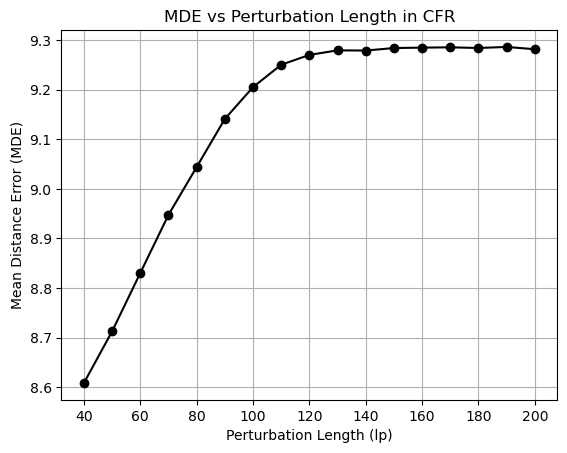

In [128]:
#plot the MDE values
import matplotlib.pyplot as plt
plt.plot(bange, mde_vals, marker='o', linestyle='-', color='black')
plt.title('MDE vs Perturbation Length in CFR')
plt.xlabel('Perturbation Length (lp)') 
plt.ylabel('Mean Distance Error (MDE)')
plt.grid(True)
plt.show()